# Energy Consumption Forecasting

## Step 1: Import Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Step 2: Load the Data

In [34]:
# Load datasets
train = pd.read_csv("data/train_energy.csv")
test = pd.read_csv("data/test_energy.csv")

# Display basic information
print("Training Data Info:")
print(train.info())
print("\nTesting Data Info:")
print(test.info())

# Display first few rows
print("\nTraining Data Sample:")
print(train.head())

print("\nTesting Data Sample:")
print(test.head())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                10249 non-null  object
 1   EnergyConsumption(kWh)  10249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.3+ KB
None

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4343 entries, 0 to 4342
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  4343 non-null   object
dtypes: object(1)
memory usage: 34.1+ KB
None

Training Data Sample:
              DateTime  EnergyConsumption(kWh)
0  2015-11-01 00:00:00                      15
1  2015-11-01 01:00:00                      13
2  2015-11-01 02:00:00                      10
3  2015-11-01 03:00:00                       7
4  2015-11-01 04:00:00                       9

Testing Data Sa

## Step 3: Basic Data Inspection and Cleaning


Missing Values in Training Data:
EnergyConsumption(kWh)    0
dtype: int64

Missing Values in Testing Data:
Series([], dtype: float64)


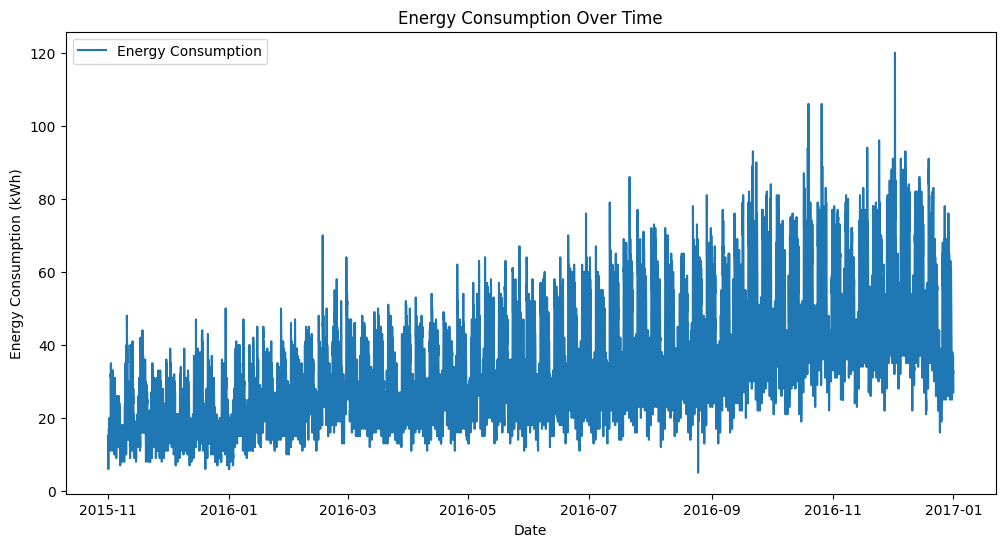

In [35]:
# Convert DateTime column to datetime object
train["DateTime"] = pd.to_datetime(train["DateTime"])
test["DateTime"] = pd.to_datetime(test["DateTime"])

# Set DateTime as index for time-series operations
train.set_index("DateTime", inplace=True)
test.set_index("DateTime", inplace=True)

# Check for missing values
print("\nMissing Values in Training Data:")
print(train.isnull().sum())

print("\nMissing Values in Testing Data:")
print(test.isnull().sum())

# Fill or interpolate missing values if necessary
train["EnergyConsumption(kWh)"] = train["EnergyConsumption(kWh)"].interpolate(method="time")

# Plot training data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["EnergyConsumption(kWh)"], label="Energy Consumption")
plt.title("Energy Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.show()

## Step 4: Outlier Detection and Removal

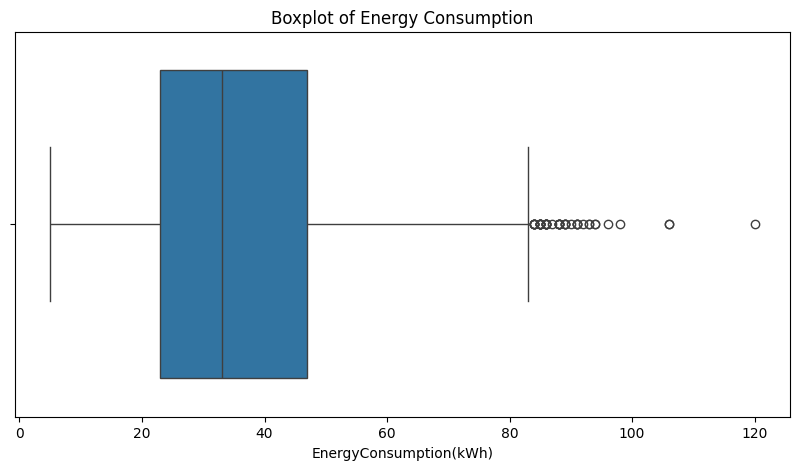

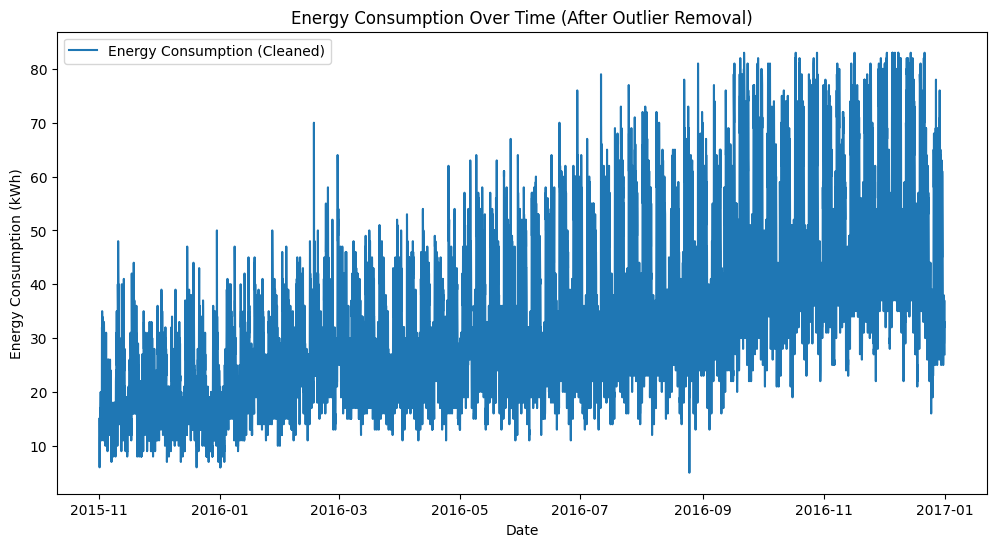

In [36]:
# Use boxplot to visualize potential outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=train["EnergyConsumption(kWh)"])
plt.title("Boxplot of Energy Consumption")
plt.show()

# Detect and remove outliers using the IQR method
q1 = train["EnergyConsumption(kWh)"].quantile(0.25)
q3 = train["EnergyConsumption(kWh)"].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter data
train = train[(train["EnergyConsumption(kWh)"] >= lower_bound) & (train["EnergyConsumption(kWh)"] <= upper_bound)]

# Replot data after outlier removal
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["EnergyConsumption(kWh)"], label="Energy Consumption (Cleaned)")
plt.title("Energy Consumption Over Time (After Outlier Removal)")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.show()

## Step 5: Feature Engineering

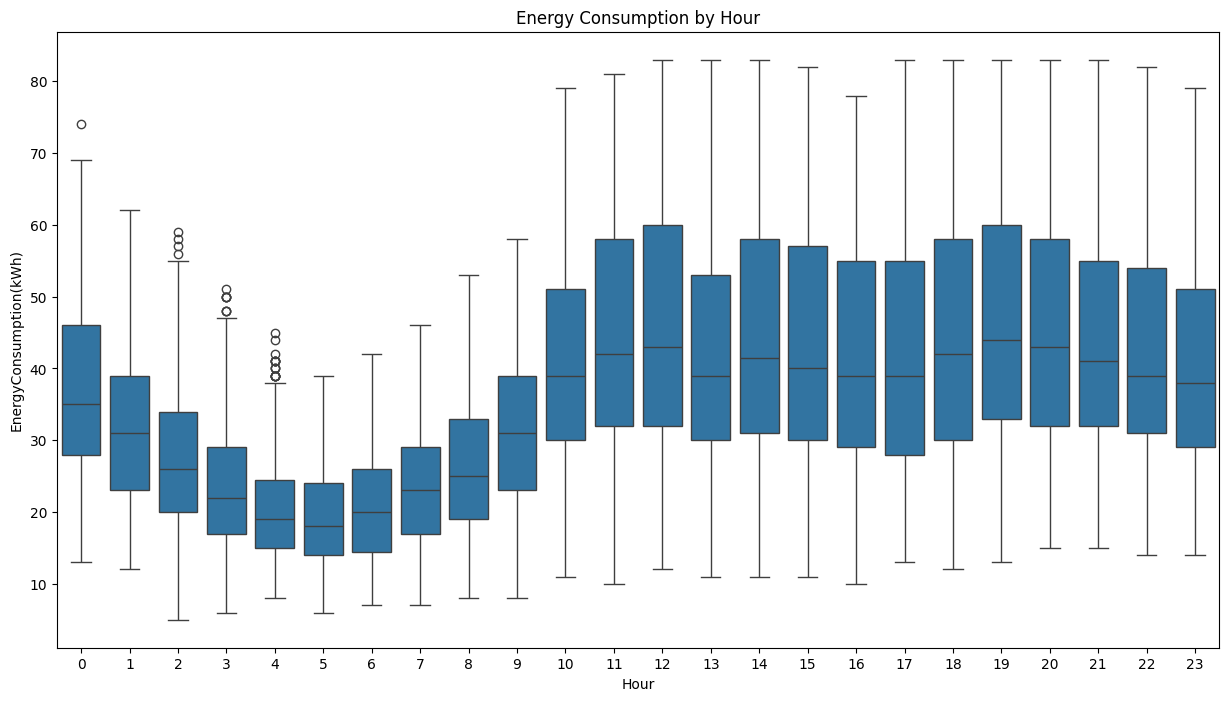

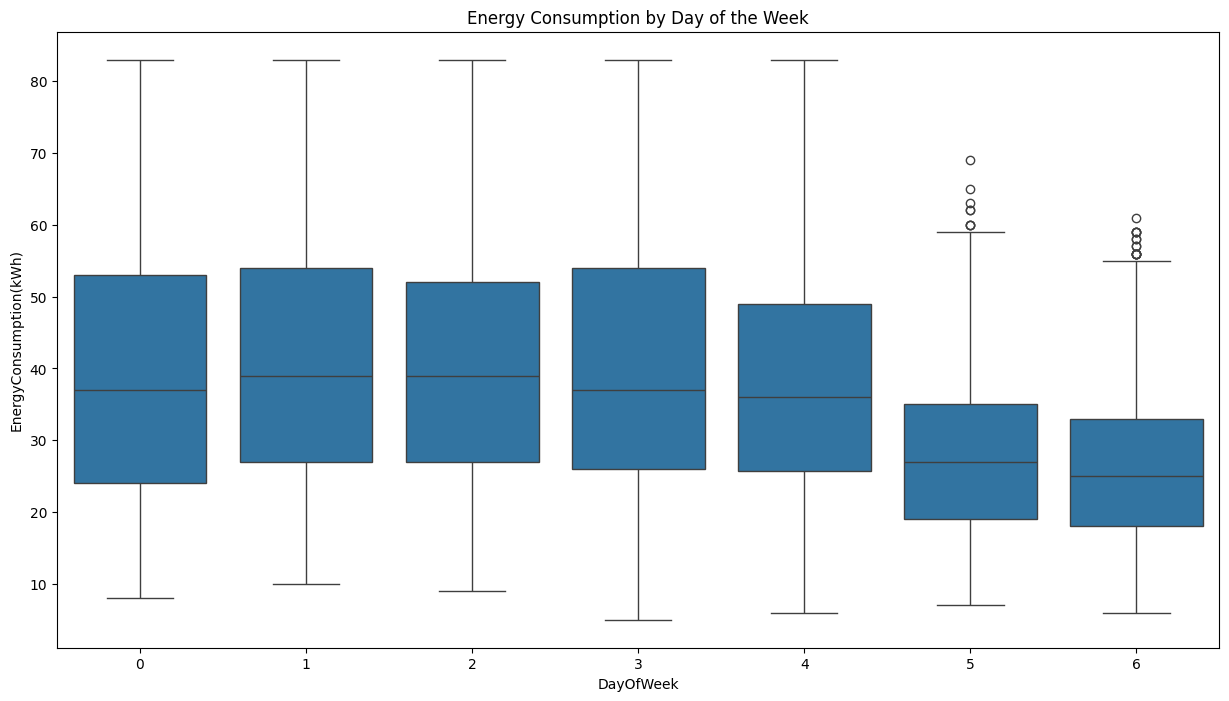

In [37]:
# Extract temporal features from the DateTime index
train["Hour"] = train.index.hour
train["DayOfWeek"] = train.index.dayofweek
train["Month"] = train.index.month
train["IsWeekend"] = train.index.dayofweek >= 5

# Plot relationships between features and target
plt.figure(figsize=(15, 8))
sns.boxplot(x="Hour", y="EnergyConsumption(kWh)", data=train)
plt.title("Energy Consumption by Hour")
plt.show()

plt.figure(figsize=(15, 8))
sns.boxplot(x="DayOfWeek", y="EnergyConsumption(kWh)", data=train)
plt.title("Energy Consumption by Day of the Week")
plt.show()

## Step 6: Stationarity Check and Transformation

In [38]:
# Perform Augmented Dickey-Fuller test
result = adfuller(train["EnergyConsumption(kWh)"], autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# If not stationary, apply differencing
if result[1] > 0.05:
    train["EnergyConsumption_Diff"] = train["EnergyConsumption(kWh)"].diff().dropna()
    train.dropna(inplace=True)

ADF Statistic: -7.201679565896205
p-value: 2.3565652984113117e-10
Critical Values: {'1%': np.float64(-3.43099360449146), '5%': np.float64(-2.8618244354026303), '10%': np.float64(-2.566921399822372)}


## Step 7: Model Building

In [39]:
# Split data into features and target
X = train[["Hour", "DayOfWeek", "Month", "IsWeekend"]]
y = train["EnergyConsumption(kWh)"]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define a baseline model (e.g., Ridge regression)
model = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

# Fit model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_val)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Validation RMSE: {rmse}")

Validation RMSE: 22.041088976671475


## Step 8: Final Model and Submission

In [40]:
# Train on full data
model.fit(X, y)

# Prepare test data features
test["Hour"] = test.index.hour
test["DayOfWeek"] = test.index.dayofweek
test["Month"] = test.index.month
test["IsWeekend"] = test.index.dayofweek >= 5

X_test = test[["Hour", "DayOfWeek", "Month", "IsWeekend"]]

# Predict on test data
test_predictions = model.predict(X_test)

# Prepare submission
submission = pd.DataFrame({
    "DateTime": test.index,
    "EnergyConsumption(kWh)": test_predictions
})
submission.to_csv("result/submission2.csv", index=False)
print("Submission file created successfully.")

Submission file created successfully.
